In [85]:
# encoding: utf-8

In [86]:
#################################
# Describe data                 #
#################################
import numpy as np
import pandas as pd

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import window as W

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import multiprocessing

In [87]:
# create SparkContext and SparkSession to process files
cores = multiprocessing.cpu_count() - 2

sc = SparkContext('local[' + str(cores) + ']', 'example')
spark = SparkSession(sc)

In [88]:
# csv files' path
my_path = '../data/'

In [89]:
app = spark.read.format('csv') \
    .option('sep', ',') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'dados_mov.csv')
app.createOrReplaceTempView("tab_app")

In [9]:
digi = spark.read.format('csv') \
    .option('sep', ',') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'dados_digi.csv')
digi.createOrReplaceTempView("tab_digi")

In [10]:
states = spark.read.format('csv') \
    .option('sep', ',') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'states.csv')
states.createOrReplaceTempView("tab_states")

In [11]:
counts = [app.count(), digi.count()]

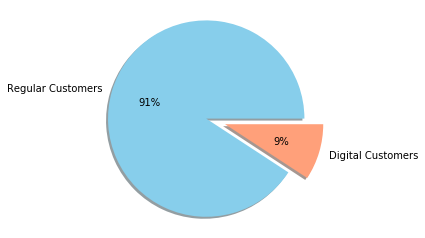

In [12]:
# quantities between common and digital accounts
rotulos = ['Regular Customers', 'Digital Customers']
quantidades = counts
explode = (.1, .1)  

fig, ax = plt.subplots()
ax.pie(quantidades, explode=explode, labels=rotulos, autopct='%1.0f%%',
        shadow=True, startangle=0, wedgeprops={'linewidth': 0}, colors=['skyblue', 'lightsalmon'])
ax.axis('equal')

plt.show()

In [13]:
gender_app = app.select('cd_sexo').groupBy('cd_sexo').count().toPandas()

In [14]:
gender_app

,cd_sexo,count
0,m,5192750
1,None,130376
2,f,4623201


In [15]:
gender_digi = digi.select('cd_sexo').groupBy('cd_sexo').count().toPandas()

In [16]:
gender_digi

,cd_sexo,count
0,m,267435
1,None,496623
2,f,246620


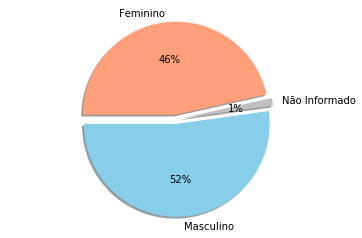

In [17]:
# quantities between male and app accounts
rotulos = ['Masculino', u'Não Informado', 'Feminino']
quantidades = gender_app['count']
explode = (.05, .05, .05)  

fig, ax = plt.subplots()
ax.pie(quantidades, explode=explode, labels=rotulos, autopct='%1.0f%%',
        shadow=True, startangle=180, wedgeprops={'linewidth': 0}, colors=['skyblue', 'silver', 'lightsalmon'])
ax.axis('equal')

plt.show()

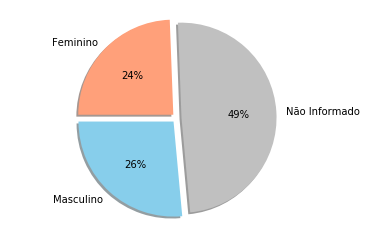

In [18]:
# quantities between male and digital accounts
rotulos = ['Masculino', u'Não Informado', 'Feminino']
quantidades = gender_digi['count']
explode = (.05, .05, .05)  

fig, ax = plt.subplots()
ax.pie(quantidades, explode=explode, labels=rotulos, autopct='%1.0f%%',
        shadow=True, startangle=180, wedgeprops={'linewidth': 0}, colors=['skyblue', 'silver', 'lightsalmon'])
ax.axis('equal')

plt.show()

In [19]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if plt.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

formatter = FuncFormatter(to_percent)    

In [20]:
ages_app = [x for x in app.select('nr_idd').rdd.flatMap(lambda x: x).collect()]

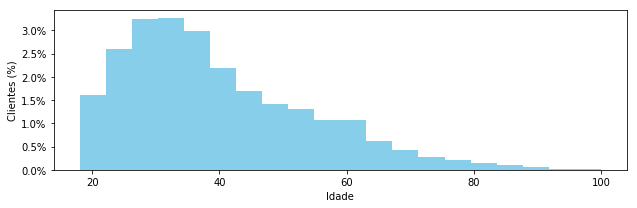

In [21]:
# age histogram
fig, ax = plt.subplots(figsize=(9, 3))

ax.hist(ages_app, 20, facecolor='skyblue', normed=True, range=(18, 100))
ax.set_xlabel(u'Idade')
ax.set_ylabel(u'Clientes (%)')

fig.tight_layout()

plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [22]:
ages_digi = [x for x in digi.select('nr_idd').rdd.flatMap(lambda x: x).collect()]

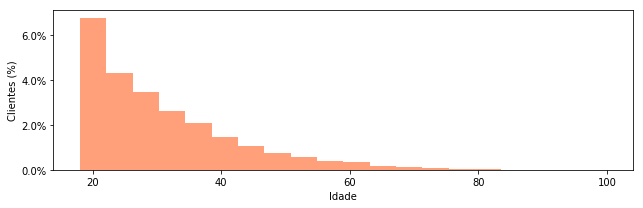

In [23]:
# age histogram
fig, ax = plt.subplots(figsize=(9, 3))

ax.hist(ages_digi, 20, facecolor='lightsalmon', normed=True, range=(18, 100))
ax.set_xlabel(u'Idade')
ax.set_ylabel(u'Clientes (%)')

fig.tight_layout()
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [24]:
cities = spark.sql("""
    select sum(c.qty_capital) as total_capital
         , sum(d.qty_other) as total_other
    from (
            select sg_uf_uor as uf
                 , count(*) as qty_capital
            from tab_app a
               , tab_states b
            where a.sg_uf_uor = b.uf
              and a.nm_mun_uor = b.nm_mun
            group by sg_uf_uor ) c
       , (
            select sg_uf_uor as uf
                 , count(*) as qty_other
            from tab_app a
               , tab_states b
            where a.sg_uf_uor = b.uf
              and a.nm_mun_uor != b.nm_mun
            group by sg_uf_uor  ) d
    where c.uf = d.uf
    
    union
    
    select sum(c.qty_capital) as total_capital
         , sum(d.qty_other) as total_other
    from (
            select sg_uf_uor as uf
                 , count(*) as qty_capital
            from tab_digi a
               , tab_states b
            where a.sg_uf_uor = b.uf
              and a.nm_mun_uor = b.nm_mun
            group by sg_uf_uor ) c
       , (
            select sg_uf_uor as uf
                 , count(*) as qty_other
            from tab_digi a
               , tab_states b
            where a.sg_uf_uor = b.uf
              and a.nm_mun_uor != b.nm_mun
            group by sg_uf_uor  ) d
    where c.uf = d.uf
    
""").toPandas()
cities

,total_capital,total_other
0,2776744,7003079
1,261334,733095


In [25]:
cities_bkp = cities

In [26]:
cities = cities_bkp

In [27]:
cities = cities.transpose()
cities.columns = ['app', 'digi']
cities

,app,digi
total_capital,2776744,261334
total_other,7003079,733095


In [28]:
sum_app = cities['app'].sum()
sum_digi = cities['digi'].sum()
print sum_app, sum_digi

9779823 994429


In [29]:
app_capital = 100 * cities.loc['total_capital', 'app'] / float(sum_app)
app_other = 100 * cities.loc['total_other', 'app'] / float(sum_app)

digi_capital = 100 * cities.loc['total_capital', 'digi'] / float(sum_digi)
digi_other = 100 * cities.loc['total_other', 'digi'] / float(sum_digi)

In [30]:
print app_capital, app_other, digi_capital, digi_other

28.392579293101726 71.60742070689827 26.27980479249901 73.72019520750099


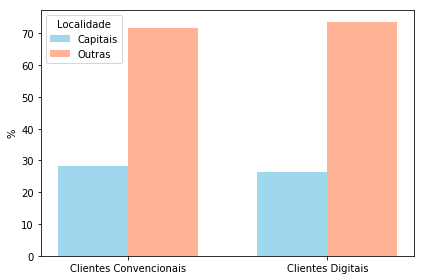

In [31]:
# create plot
import numpy as np
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, [app_capital, digi_capital], bar_width,
                 alpha=opacity,
                 color='skyblue',
                 label='Capitais')

rects2 = plt.bar(index + bar_width, [app_other, digi_other], bar_width,
                 alpha=opacity,
                 color='lightsalmon',
                 label='Outras')

# plt.xlabel(i)
plt.ylabel('%')
#     plt.title('Scores by person')
plt.xticks(index + .5 * bar_width, ('Clientes Convencionais', 'Clientes Digitais'))
plt.legend(title='Localidade')

plt.tight_layout()
plt.show()


In [32]:
wages = spark.sql("""
    select wage
         , count(*) as qty
    from ( select case 
                      when vl_rend >= 10000 then 'Above'
                      else 'Below'
                  end as wage
           from tab_app )
    group by wage
""").toPandas()
wages

,wage,qty
0,Above,981383
1,Below,8964944


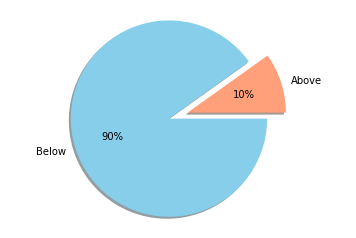

In [33]:
# pie about wages
rotulos = wages['wage']
quantidades = wages['qty']
explode= [.1, .1]

fig, ax = plt.subplots()
ax.pie(quantidades, explode=explode, labels=rotulos, autopct='%1.0f%%',
        shadow=True, startangle=0, wedgeprops={'linewidth': 0}, colors=['lightsalmon', 'skyblue'])
ax.axis('equal')

plt.show()

In [34]:
products = spark.sql("""
    select wage
         , round(avg(qt_prd_obsd)) as media
         , round(std(qt_prd_obsd)) as desvio
    from
    ( select case 
                when vl_rend < 1000 then '[0,01, 1000)'
                when vl_rend >= 1000 and vl_rend < 4000 then '[1000, 4000)'
                when vl_rend >= 4000 and vl_rend < 10000 then '[4000, 10000)'
                when vl_rend >= 10000 then '[10000, +Inf)'
             end as wage
           , qt_prd_obsd  
      from tab_app )
    group by wage
""").toPandas()
products

,wage,media,desvio
0,"[0,01, 1000)",3.0,2.0
1,"[1000, 4000)",4.0,2.0
2,"[10000, +Inf)",7.0,3.0
3,"[4000, 10000)",6.0,3.0


In [35]:
correlation = spark.sql("""
    select '< 10000' as wage 
         , corr(vl_rend, vl_mgct_obsd)
    from tab_app
    where vl_rend < 10000
    
    union
    
    select '>= 10000' as wage 
         , corr(vl_rend, vl_mgct_obsd)
    from tab_app
    where vl_rend >= 10000
    
""").show()

+--------+---------------------------+
|    wage|corr(vl_rend, vl_mgct_obsd)|
+--------+---------------------------+
| < 10000|        0.03594772819552715|
|>= 10000|        0.37485985898903057|
+--------+---------------------------+



In [36]:
spark.sql("""
    select wage
         , corr(vl_rend, vl_mgct_obsd)
    from 
     ( select case 
                when vl_rend < 1000 then '[0,01, 1000)'
                when vl_rend >= 1000 and vl_rend < 4000 then '[1000, 4000)'
                when vl_rend >= 4000 and vl_rend < 10000 then '[4000, 10000)'
                when vl_rend >= 10000 then '[10000, +Inf)'
             end as wage
           , vl_mgct_obsd
           , vl_rend
      from tab_app )
    group by wage
""").show()      

+-------------+---------------------------+
|         wage|corr(vl_rend, vl_mgct_obsd)|
+-------------+---------------------------+
| [0,01, 1000)|       0.005935508907984275|
| [1000, 4000)|       0.014047178358049747|
|[10000, +Inf)|        0.37485985898903057|
|[4000, 10000)|        0.07773607204270204|
+-------------+---------------------------+



In [147]:
ex = spark.read.format('csv') \
    .option('sep', ',') \
    .option('header', 'True') \
    .option('inferSchema', 'True') \
    .load(my_path + 'dados_ref_ex.csv')
ex.createOrReplaceTempView("tab_ex")

In [148]:
# remove duplicated info, keeping the most recent per customer.

ex = spark.sql("""
     select A.cd_cpf
          , A.vl_ref_ex
     from tab_ex A
        , (select cd_cpf
                , max(dt_ref_ex) as dt_ref_ex
           from tab_ex
           group by cd_cpf) B
     where A.cd_cpf    = B.cd_cpf
       and A.dt_ref_ex = B.dt_ref_ex
""")
ex.createOrReplaceTempView("tab_ex")

In [149]:
vl_ex = [x for x in spark.sql("""
    select a.vl_ref_ex
    from tab_ex a
       , tab_app b
    where a.cd_cpf = b.cd_cpf
""").rdd.flatMap(lambda x: x).collect()]

In [60]:
vl_app = [x for x in app.select('vl_rend').rdd.flatMap(lambda x: x).collect()]

In [41]:
vl_ex_50 = [v for v in vl_ex if v > 0 and v < 5*10**4]

In [42]:
vl_app_50 = [v for v in vl_app if v > 0 and v < 5*10**4]

In [43]:
min_bin = np.min(vl_app_50 + vl_ex_50)

In [44]:
max_bin = np.max(vl_app_50 + vl_ex_50)

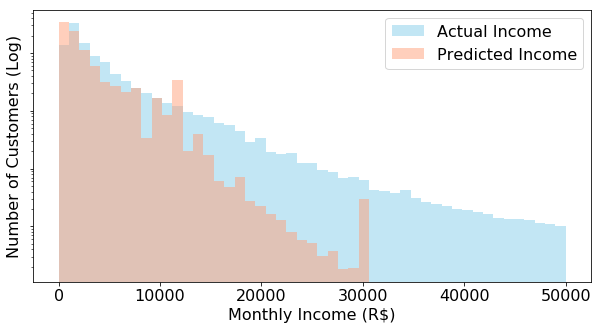

In [57]:
bins = np.linspace(min_bin, max_bin, 50)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(vl_app_50, bins, alpha=.5 ,label='Actual Income', color='skyblue', log=True)
ax.hist(vl_ex_50, bins, alpha=.5, label='Predicted Income', color='lightsalmon', log=True)
ax.set_ylabel('Number of Customers (Log)')
ax.set_xlabel('Monthly Income (R$)')
ax.legend(loc='upper right')
# plt.gca().yaxis.set_visible(False)

# Turn off tick labels
ax.set_yticklabels([])

plt.rcParams.update({'font.size': 16})

plt.show()

In [46]:
spark.sql("""
    select wage
         , corr(vl_rend, vl_ref_ex)
    from 
     ( select case 
                when vl_rend < 1000 then '[0,01, 1000)'
                when vl_rend >= 1000 and vl_rend < 4000 then '[1000, 4000)'
                when vl_rend >= 4000 and vl_rend < 10000 then '[4000, 10000)'
                when vl_rend >= 10000 then '[10000, +Inf)'
             end as wage
           , vl_ref_ex
           , vl_rend
      from (select a.vl_rend, b.vl_ref_ex from tab_app a, tab_ex b where a.cd_cpf = b.cd_cpf) )
    group by wage
""").show()     

+-------------+------------------------+
|         wage|corr(vl_rend, vl_ref_ex)|
+-------------+------------------------+
| [0,01, 1000)|    -0.05611598168823669|
| [1000, 4000)|     0.14783979314569573|
|[10000, +Inf)|    0.029072782238118596|
|[4000, 10000)|     0.19662950587824937|
+-------------+------------------------+



In [47]:
spark.sql("""
    select avg(vl_ref_ex / float(vl_rend))
    from (select a.vl_rend
               , b.vl_ref_ex 
          from tab_app a
             , tab_ex  b 
          where a.cd_cpf = b.cd_cpf 
            and a.vl_rend >= 10000)
""").show()

+---------------------------------------------------------+
|avg((vl_ref_ex / CAST(CAST(vl_rend AS FLOAT) AS DOUBLE)))|
+---------------------------------------------------------+
|                                      0.40593399759017734|
+---------------------------------------------------------+



In [ ]:
spark.sql("""
    select avg(vl_ref_ex / float(vl_rend))
    from (select a.vl_rend
               , b.vl_ref_ex 
          from tab_app a
             , tab_ex  b 
          where a.cd_cpf = b.cd_cpf 
            and a.vl_rend < 10000)
""").show()

In [ ]:
spark.sql("""
    select wage
         , avg(vl_rend)
    from 
     ( select case 
                when vl_rend < 1000 then '[0,01, 1000)'
                when vl_rend >= 1000 and vl_rend < 4000 then '[1000, 4000)'
                when vl_rend >= 4000 and vl_rend < 10000 then '[4000, 10000)'
                when vl_rend >= 10000 then '[10000, +Inf)'
             end as wage
           , vl_rend
      from tab_app )
    group by wage
""").show()  

In [90]:
joinville = [ x for x in app.select('vl_rend') \
                            .where('nm_mun_uor = "joinville" and sg_uf_uor = "sc"') \
                            .rdd \
                            .flatMap(lambda x: x) \
                            .collect() ]

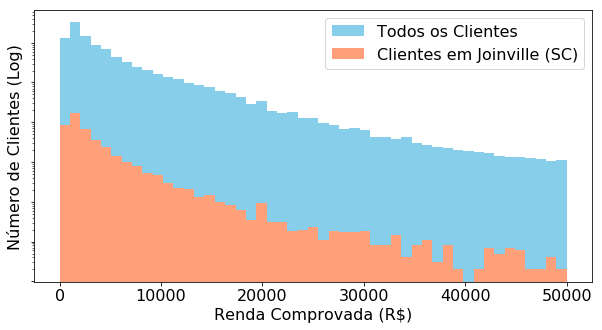

In [158]:
bins = np.linspace(0, 50000, 50)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(vl_app, bins, label='Todos os Clientes', color='skyblue', log=True)
ax.hist(joinville, bins, label='Clientes em Joinville (SC)', color='lightsalmon', log=True)
ax.set_ylabel(u'Número de Clientes (Log)')
ax.set_xlabel('Renda Comprovada (R$)')
ax.legend(loc='upper right')
# plt.gca().yaxis.set_visible(False)

# Turn off tick labels
ax.set_yticklabels([])

plt.rcParams.update({'font.size': 16})

plt.show()

In [93]:
print np.mean(joinville), np.std(joinville)

3514.518991716082 13694.298527957026


In [94]:
print np.mean(vl_app), np.std(vl_app)

4769.042523723583 24901.691122514603


In [107]:
obs_1 = np.sum([1 for x in joinville if x >= 10000])
obs_0 = len(joinville) - obs_1

print obs_0, obs_1

43011 2016


In [108]:
exp_1 = np.sum([1 for x in vl_app if x >= 10000]) * len(joinville) / np.float(len(vl_app))
exp_0 = len(joinville) - exp_1

print exp_0, exp_1

40584.281362155096 4442.718637844905


In [106]:
from scipy.stats import chisquare

chi, p = chisquare(f_obs=[obs_0, obs_1], f_exp=[exp_0, exp_1])

p

0.0

In [125]:
false_rate = [100 * obs_0 / np.float(len(joinville)), 100 * exp_0 / np.float(len(joinville))]
false_rate

[95.5226863881671, 90.13321198870699]

In [126]:
true_rate = [100 * obs_1 / np.float(len(joinville)), 100 * exp_1 / np.float(len(joinville))]
true_rate

[4.4773136118329, 9.866788011293012]

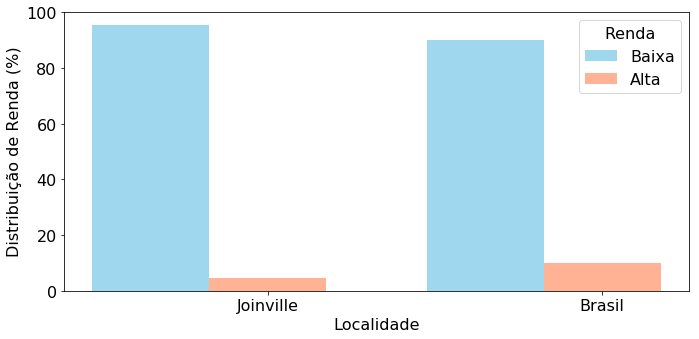

In [142]:
# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(2)
# bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, false_rate, bar_width,
                 alpha=opacity,
                 color='skyblue',
                 label='Baixa')

rects2 = plt.bar(index + bar_width, true_rate, bar_width,
                 alpha=opacity,
                 color='lightsalmon',
                 label='Alta')

plt.xlabel(u'Localidade')
plt.ylabel(u'Distribuição de Renda (%)')
#     plt.title('Scores by person')
plt.xticks(index + bar_width, ('Joinville', 'Brasil'))
plt.legend(title='Renda', loc='upper right') #, prop={'size': 14})

plt.tight_layout()
plt.show()

In [150]:
jv_ex = [ x for x in spark.sql("""
    select a.vl_ref_ex 
    from tab_ex a
       , tab_app b
    where a.cd_cpf = b.cd_cpf
      and b.nm_mun_uor = 'joinville' and b.sg_uf_uor = 'sc'
""").rdd \
    .flatMap(lambda x: x) \
    .collect() ]

In [153]:
jv_ex_50 = [x for x in jv_ex if x <= 50000]

In [154]:
bra_ex = [ x for x in spark.sql("""
    select a.vl_ref_ex 
    from tab_ex a
       , tab_app b
    where a.cd_cpf = b.cd_cpf
""").rdd \
    .flatMap(lambda x: x) \
    .collect() ]

In [155]:
bra_ex_50 = [x for x in bra_ex if x <= 50000]

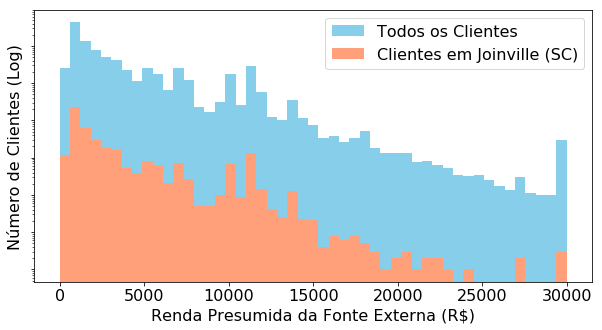

In [157]:
bins = np.linspace(0, 30000, 50)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(bra_ex_50, bins, label='Todos os Clientes', color='skyblue', log=True)
ax.hist(jv_ex_50, bins, label='Clientes em Joinville (SC)', color='lightsalmon', log=True)
ax.set_ylabel(u'Número de Clientes (Log)')
ax.set_xlabel('Renda Presumida da Fonte Externa (R$)')
ax.legend(loc='upper right')
# plt.gca().yaxis.set_visible(False)

# Turn off tick labels
ax.set_yticklabels([])

plt.rcParams.update({'font.size': 16})

plt.show()

In [84]:
sc.stop()